# Introduction
The goal of this notebook is to illustrate the `jump` functionality of QSP notebook using examples inspired from various ABM projects. A `jump` in V2 identical to a `route` in the way it is coded. When we say `jump` we mean an effect which changes a state of a model to a specific value on a `schedule` and could be any expression of parameters, assignments and states (e.g., `state = 0`, `state = state/2 + parameter1`, etc). However, `routes` imply *additive* effects (e.g., `state += amt * multiplier` adds `amt * multiplier` to the `state`). This sets up `jump` as a powerful modeling tool.


In a model text file, the following syntax is used for jumps:
<code>
jump1_name = @(times=[...]); state1 = state1_post_jump1, state2 = state2_post_jump1
jump2_name = @(start=..., interval=..., n=...); state1 = state1_post_jump2, state2 = state2_post_jump2
</code>

It is important to note that all imputs with units need to have units explicitly listed. For example, if jump1_name was applied at 0s and 1d you would enter `times = [0:s,1:d]`. 


**Remark:**
It is possible to have multiple `routes` and/or `jumps` occur at a given time. In such a case, first all the routes are evaluated in the order of their appearance in the model. Then, all jumps are evaluated in the order of their appearance in the model. For example, a model comprising a route
`route1 = ListSchedule(times=[0:s], amounts=[1:1]); x += amt`
and the jump
`jump1 = ListJumpSchedule(times=[0:s]); x = 0.5 * x`
would evaluate the state $x(t=0_+)$ as $0.5 * (x(t=0)+1)$.

**Contents:**
- Example 1: Preconditioning model states before dosing (uses base framework and erythropoiesis model)
- Example 2: Testing model mechanisms by resetting model states (uses base framework and thrombocytopenia model)
- Example 3: Creating in-vitro experiments (e.g. ice incubation) by using jumps to reset parameters (uses base framework and ADC in vitro model)
- Example 4: Running model species to steady state with time-dependent compartment volumes (e.g. tumor) (uses python simulation framework and TGI with soluble target model)

In [1]:
# abm modules
from abm import *

# other python modules
import pandas as pd
import numpy as np
import scipy.stats as stats

# we use plotly for visualizations
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotnine as p9

# default settings for plotly
abm_primary_palette = ['#008962', '#032E2D']
pio.templates['my_abm'] = go.layout.Template(
    layout = go.Layout(
        title = {'font':{'color': abm_primary_palette[1], 'size': 20}},
        font = {'color': abm_primary_palette[1]},
        xaxis = {'showgrid': True,
                 'ticks': 'inside',
                 'title': {'font':{'color': abm_primary_palette[1]}},
                 'spikethickness': 1,
                 'spikedash': 'dot'
                },
        yaxis = {'showgrid': True,
                 'ticks': 'inside',
                 'title': {'font':{'color': abm_primary_palette[1]}},
                 'spikethickness': 1,
                 'spikedash': 'dot'
                },
        legend = {'title': {'font':{'color': abm_primary_palette[1]}}
                }
    )
)

# set default template
pio.templates.default = 'seaborn+my_abm'

# Example 1: Reset a subset of model states to mimic host preconditioning 
Host preconditioning refers to the treatment or irradition of the host preceding a transplantation, resulting in depleted endogenous cells. The goal of preconditioning is to create a niche before engraftment. We use a simplified version model by [Zheng et al, CPT Pharmacometrics Syst. Pharmacol. 2021](https://doi.org/10.1002/psp4.12638) that describes erythropoiesis. We use a jump to deplete a fraction of the cells in bonemarrow. Both the time of the jump as well the fraction of cells that are depleted are parameterized.

## creating simulation

In [14]:
output_times = linspace(0, 250*86400, 10001, 's')
output_names = ['lt', 'st', 'mpp', 'cmp', 'bfue', 'cfue', 'ret', 'rbc']
df_sim_model1 = simulate(
    models="model_jumps_1.model",
    times=output_times,
    outputs = output_names,
    reltol = 1e-6,
    abstol = 1e-12,
    nonnegative = True).to_pandas(tall_outputs = True)

'Total: 1, Running: 0, Succeeded: 1, Failed: 0, Stopped: 0'

Simulations finished


In [3]:
df_sim_model1['t_days'] = df_sim_model1['t']/86400
df_sim_model1.head()

,id,t,output,value,output_unit,t_days
0,0,0.0,lt,1.275000e+03,1,0.0
1,0,0.0,st,2.550000e+02,1,0.0
2,0,0.0,mpp,2.550000e+04,1,0.0
3,0,0.0,cmp,5.100000e+07,1,0.0
4,0,0.0,bfue,1.428000e+09,1,0.0


/tmp/ipykernel_21696/3956956549.py:11: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


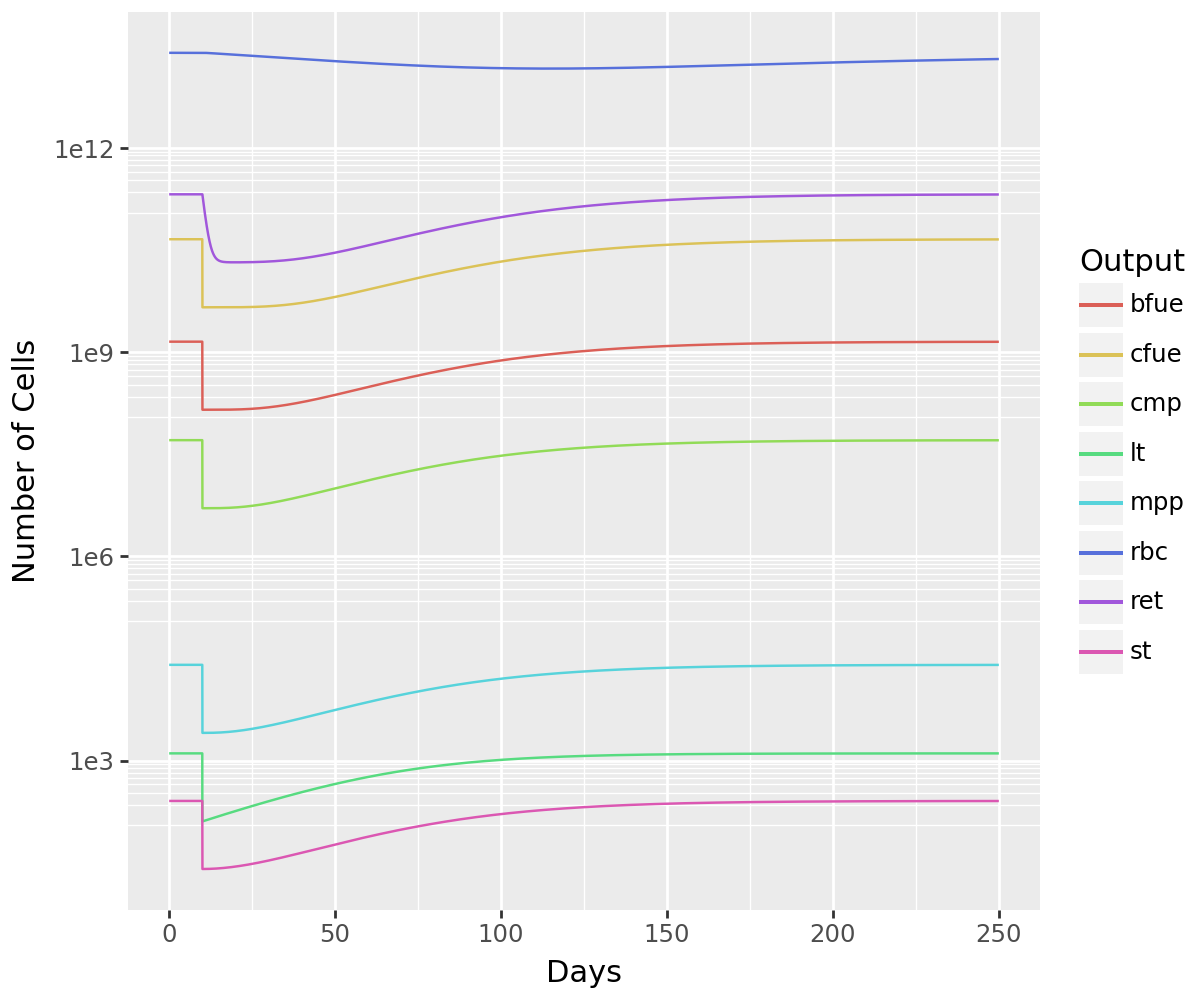

In [4]:
fig = (
p9.ggplot(df_sim_model1, mapping = p9.aes('t_days', y = 'value',
                                                  color='factor(output)'))
    + p9.geom_line()
    + p9.labs(x = 'Days', y = 'Number of Cells', color = 'Output')
    + p9.theme(figure_size = (6,5))
    + p9.scale_y_log10()
)


print(fig)

# Example 2: Testing negative feedback based homeostasis by perturbing the regulated state

This example uses a model of thrombopoiesis. Whereas thrombopoiesis is a similar process to erythropoiesis (in the Example 1), we use a simplified model that does not account for all the pregenitors of platelets in the bonemarrow but instead assume arrival of CFU-MK (colony forming unit megakaryocytes, similar to CFU-E in Example 1) at a constant rate from its precursors. In addition to this simplification, we also include a negative feedback mechanism that counters perturbation in platelets.

Here, we test this negative feedback by periodically resetting the platelet level through a jump.

In [5]:
output_times = linspace(0, 5 * 86400, 10001, 's')
output_names = ['cfu', 'mk', 'plt']

df_sim_model2 = simulate(
    models = "model_jumps_2.model",
    times = output_times,
    outputs = output_names,
    abstol=1e-12,
    reltol=1e-6,
    nonnegative=True).to_pandas(tall_outputs = True)

'Total: 1, Running: 0, Succeeded: 1, Failed: 0, Stopped: 0'

Simulations finished


In [6]:
df_sim_model2['t_days'] = df_sim_model2['t']/86400
df_sim_model2.head()

,id,t,output,value,output_unit,t_days
0,0,0.0,cfu,984768.814231,1,0.0000
1,0,0.0,mk,65651.255216,1,0.0000
2,0,0.0,plt,1000.000000,1,0.0000
3,0,43.2,cfu,984768.814234,1,0.0005
4,0,43.2,mk,72698.047401,1,0.0005


/tmp/ipykernel_21696/2473219837.py:11: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


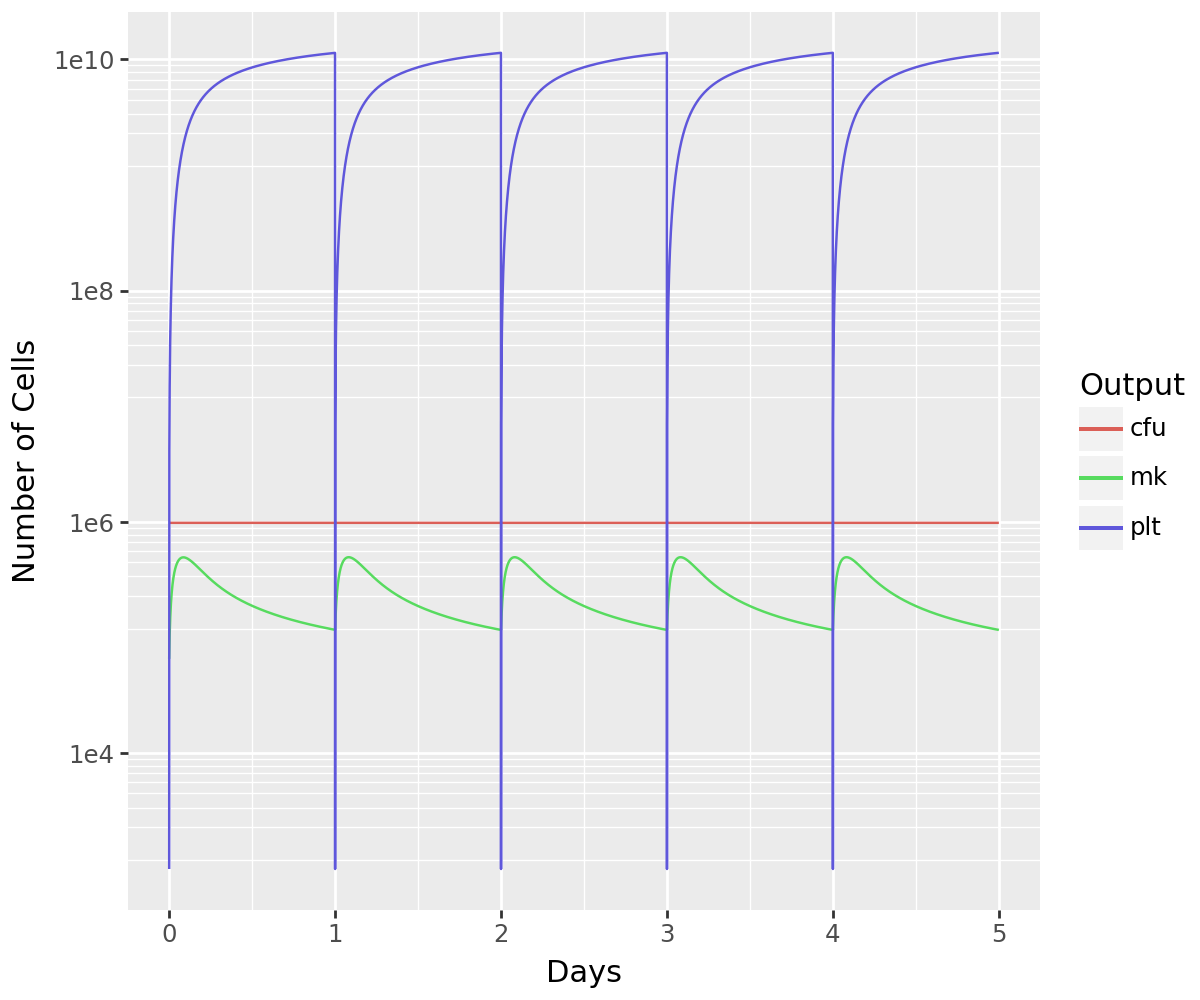

In [7]:
fig = (
p9.ggplot(df_sim_model2, mapping = p9.aes('t_days', y = 'value',
                                                  color='factor(output)'))
    + p9.geom_line()
    + p9.labs(x = 'Days', y = 'Number of Cells', color = 'Output')
    + p9.theme(figure_size = (6,5))
    + p9.scale_y_log10()
)


print(fig)

## Example 3: Media replacement in an in-vitro experiment (using simulation framework)

The *in-vitro* experiment is set-up as follows:
1. Start with the model initialized at steady-state
2. Setup a model run where cells are in ice (so only BINDING takes place; all other parameters are zero)
3. Grab the steady-state from this model and initialize a new model with these steady-states

In our model, we have a dummy state `media_indicator` that is set to 1 by default, but can be switched to zero using jump/routes.

### Dose and simulation tables

In [8]:
Tdos3 = pd.DataFrame(
    {'dose_nmol': [0.0016] ,
     'route':['IV_Ab_nmol'],
     'amounts':[0.0016],
     'amount_unit':['nmol'],
     'times':[0],
     'time_unit':['d']})

Tsim3 = Tdos3.dose_nmol.to_frame()

display(Tdos3)
display(Tsim3)

,dose_nmol,route,amounts,amount_unit,times,time_unit
0,0.0016,IV_Ab_nmol,0.0016,nmol,0,d


,dose_nmol
0,0.0016


In [9]:
output_names = ['R', 'Ab_0', 'Ab_R', 'R_endo', 'Ab_R_endo']


df_sim_model3 = simulate(
    models="model_jumps_3.model",
    simulations=Tsim3,
    parameters="model_3_parameter_table.csv",
    doses=Tdos3,
    times=linspace(0, 0.25, 1001, 'd'), 
    outputs=output_names,
    abstol = 1e-15,
    reltol = 1e-6).to_pandas(tall_outputs=True)

df_sim_model3

'Total: 1, Running: 0, Succeeded: 1, Failed: 0, Stopped: 0'

Simulations finished


,dose_nmol,id,t,output,value,output_unit
0,0.0016,0,0.0,R,0.003188,nmol
1,0.0016,0,0.0,Ab_0,0.001600,nmol
2,0.0016,0,0.0,Ab_R,0.000000,nmol
3,0.0016,0,0.0,R_endo,0.003157,nmol
4,0.0016,0,0.0,Ab_R_endo,0.000000,nmol
...,...,...,...,...,...,...
5000,0.0016,0,21600.0,R,0.003089,nmol
5001,0.0016,0,21600.0,Ab_0,0.000060,nmol
5002,0.0016,0,21600.0,Ab_R,0.000099,nmol
5003,0.0016,0,21600.0,R_endo,0.003006,nmol


/tmp/ipykernel_21696/2338106624.py:12: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


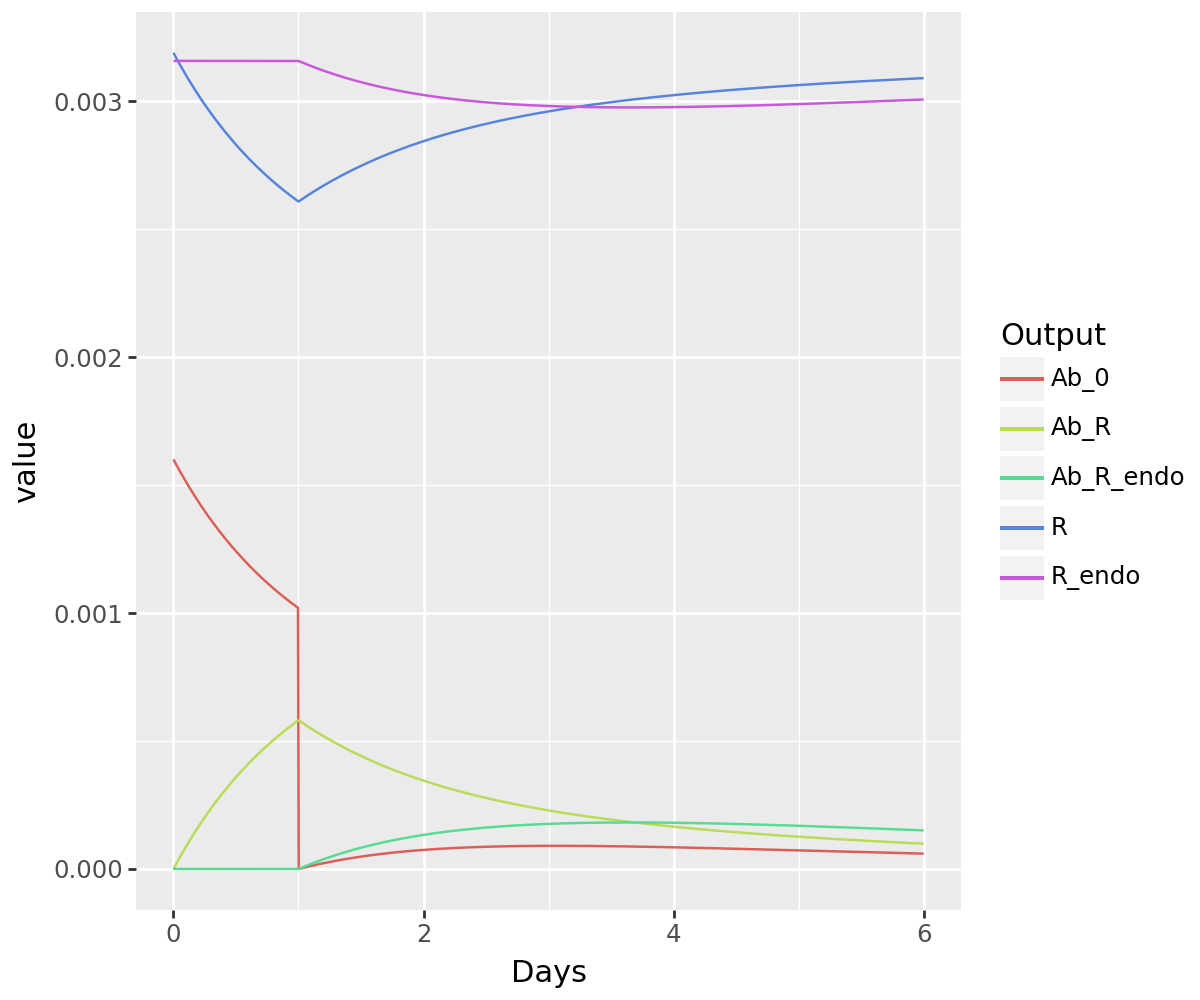

In [10]:
df_sim_model3['t_hrs'] = df_sim_model3['t']/3600

fig = (
p9.ggplot(df_sim_model3, mapping = p9.aes('t_hrs', y = 'value',
                                                  color='factor(output)'))
    + p9.geom_line()
    + p9.labs(x = 'Days', color = 'Output')
    + p9.theme(figure_size = (6,5))
)


print(fig)

# Example 4: Initializing molecular species in a multi-scale tumor growth dynamics model

We often get data on tumor growth inhibition upon administration of a drug. We'd like to run the model to steady state for receptor dynamics (receptor sheds and distributes) at a nominal tumor size. Since jumps are not executed during initialization, we can set tumor growth to be off during initialization and then use the jump to turn on growth when the simulation is run. 

Note: this could also be implemented using a route by setting the state `indicator_growth_tumor` to 1 (`indicator_growth_tumor` = 0 is default and corresponds to no tumor growth; route turns growth on).

### setting up simulations

In [11]:
output_times = linspace(0, 60 * 86400, 1001, 's')
output_names = ['Ncell_tumor', 'R_tumor', 'solR_tumor', 'solR_central']

df_sim_model4 = simulate(
    models="model_jumps_4.model",
    times=output_times,
    outputs = output_names,
    abstol=1e-12,
    reltol=1e-6,
    nonnegative = True).to_pandas(tall_outputs = True)

'Total: 1, Running: 0, Succeeded: 1, Failed: 0, Stopped: 0'

Simulations finished


In [12]:
df_sim_model4['t_days'] = df_sim_model4['t']/86400
df_sim_model4.head()

,id,t,output,value,output_unit,t_days
0,0,0.0,Ncell_tumor,1.000000e+09,1,0.00
1,0,0.0,R_tumor,4.151445e-01,nmol,0.00
2,0,0.0,solR_tumor,1.495017e-01,nmol,0.00
3,0,0.0,solR_central,4.670676e-02,nmol,0.00
4,0,5184.0,Ncell_tumor,1.006256e+09,1,0.06


/tmp/ipykernel_21696/699983460.py:11: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


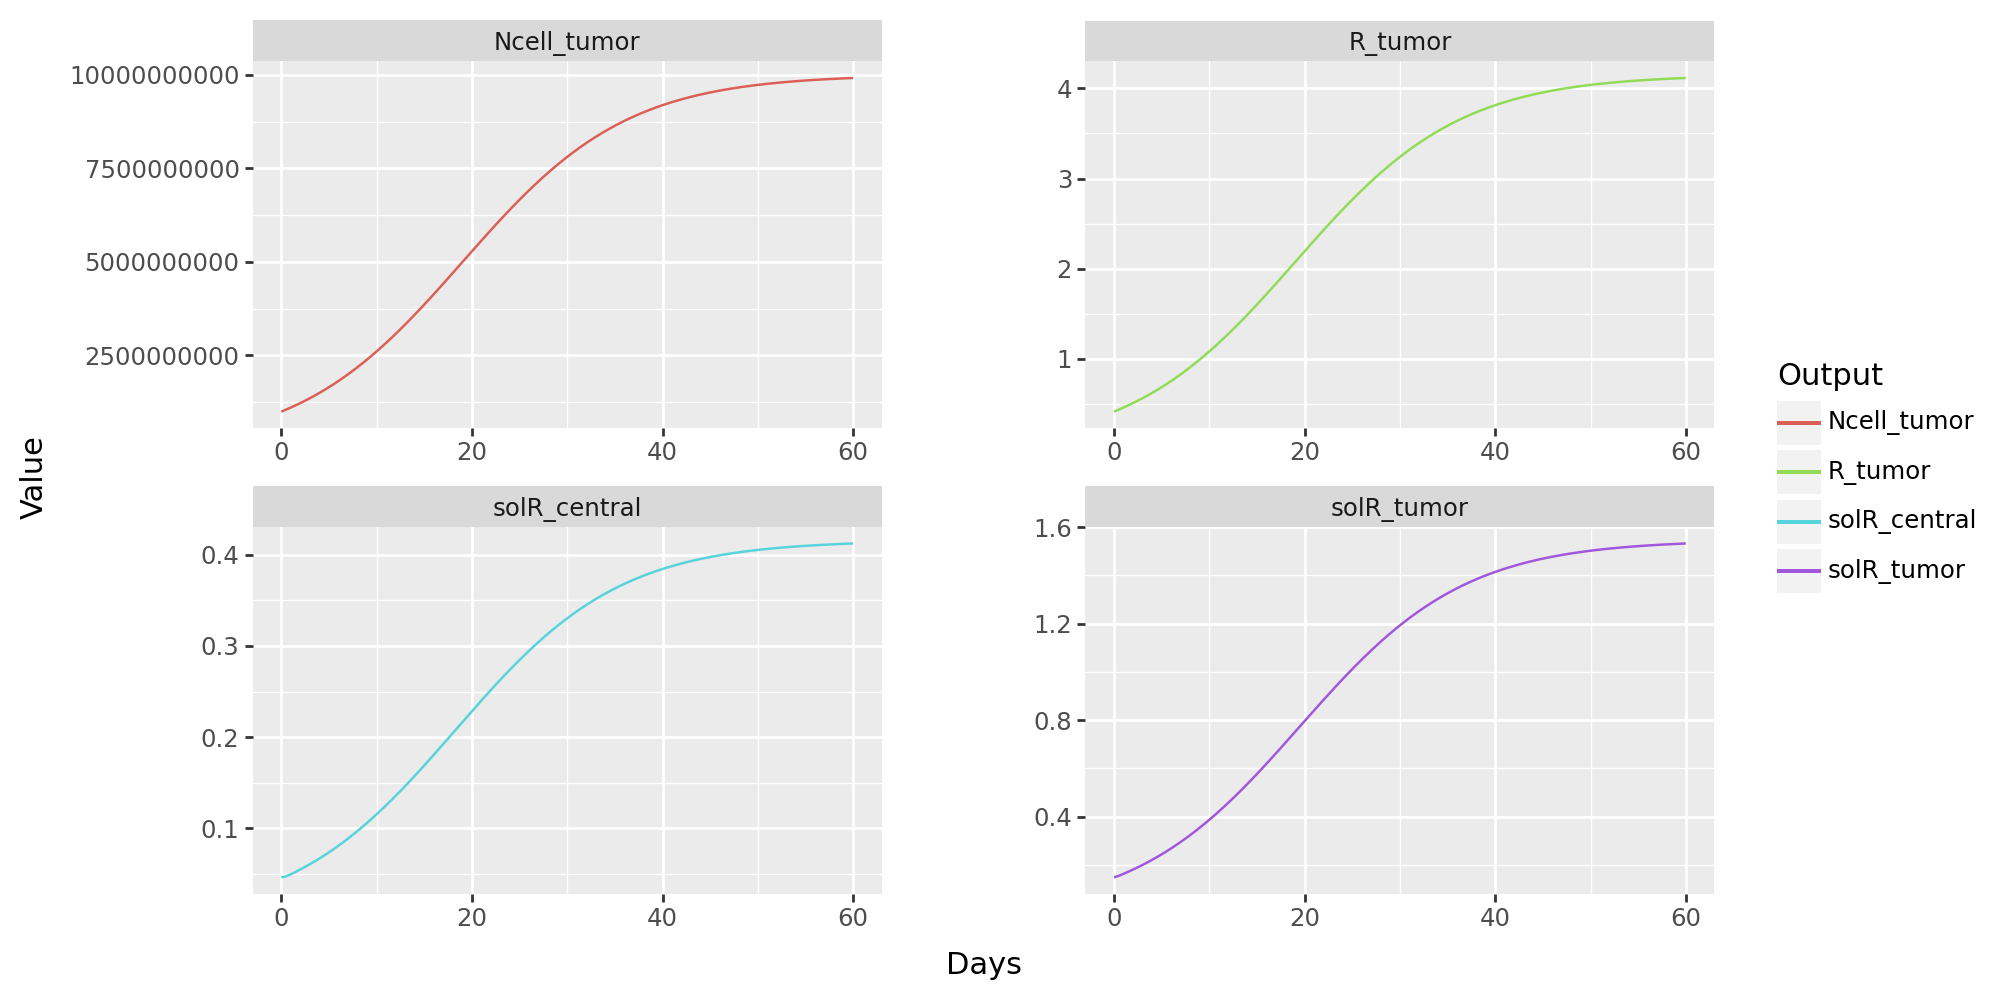

In [13]:
fig = (
p9.ggplot(df_sim_model4, mapping = p9.aes('t_days', y = 'value',
                                                  color='factor(output)'))
    + p9.geom_line()
    + p9.labs(x = 'Days', y = 'Value', color = 'Output')
    + p9.facet_wrap('output', ncol = 2, scales = 'free')
    + p9.theme(figure_size = (10,5))
    #+ p9.scale_y_log10()
)

print(fig)